# Exploration of Raw Meshes

In [1]:
import os
import random
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import numpy as np

from dotenv import load_dotenv

load_dotenv()

True

In [2]:
RAW_MESHES_DIR = os.path.join(os.getenv('DATA_DIR_PATH'), 'raw')

In [3]:
stl_files = [file for file in os.listdir(RAW_MESHES_DIR) if file.endswith(".stl")]
len(stl_files)

208

## Taking a look at the meshes

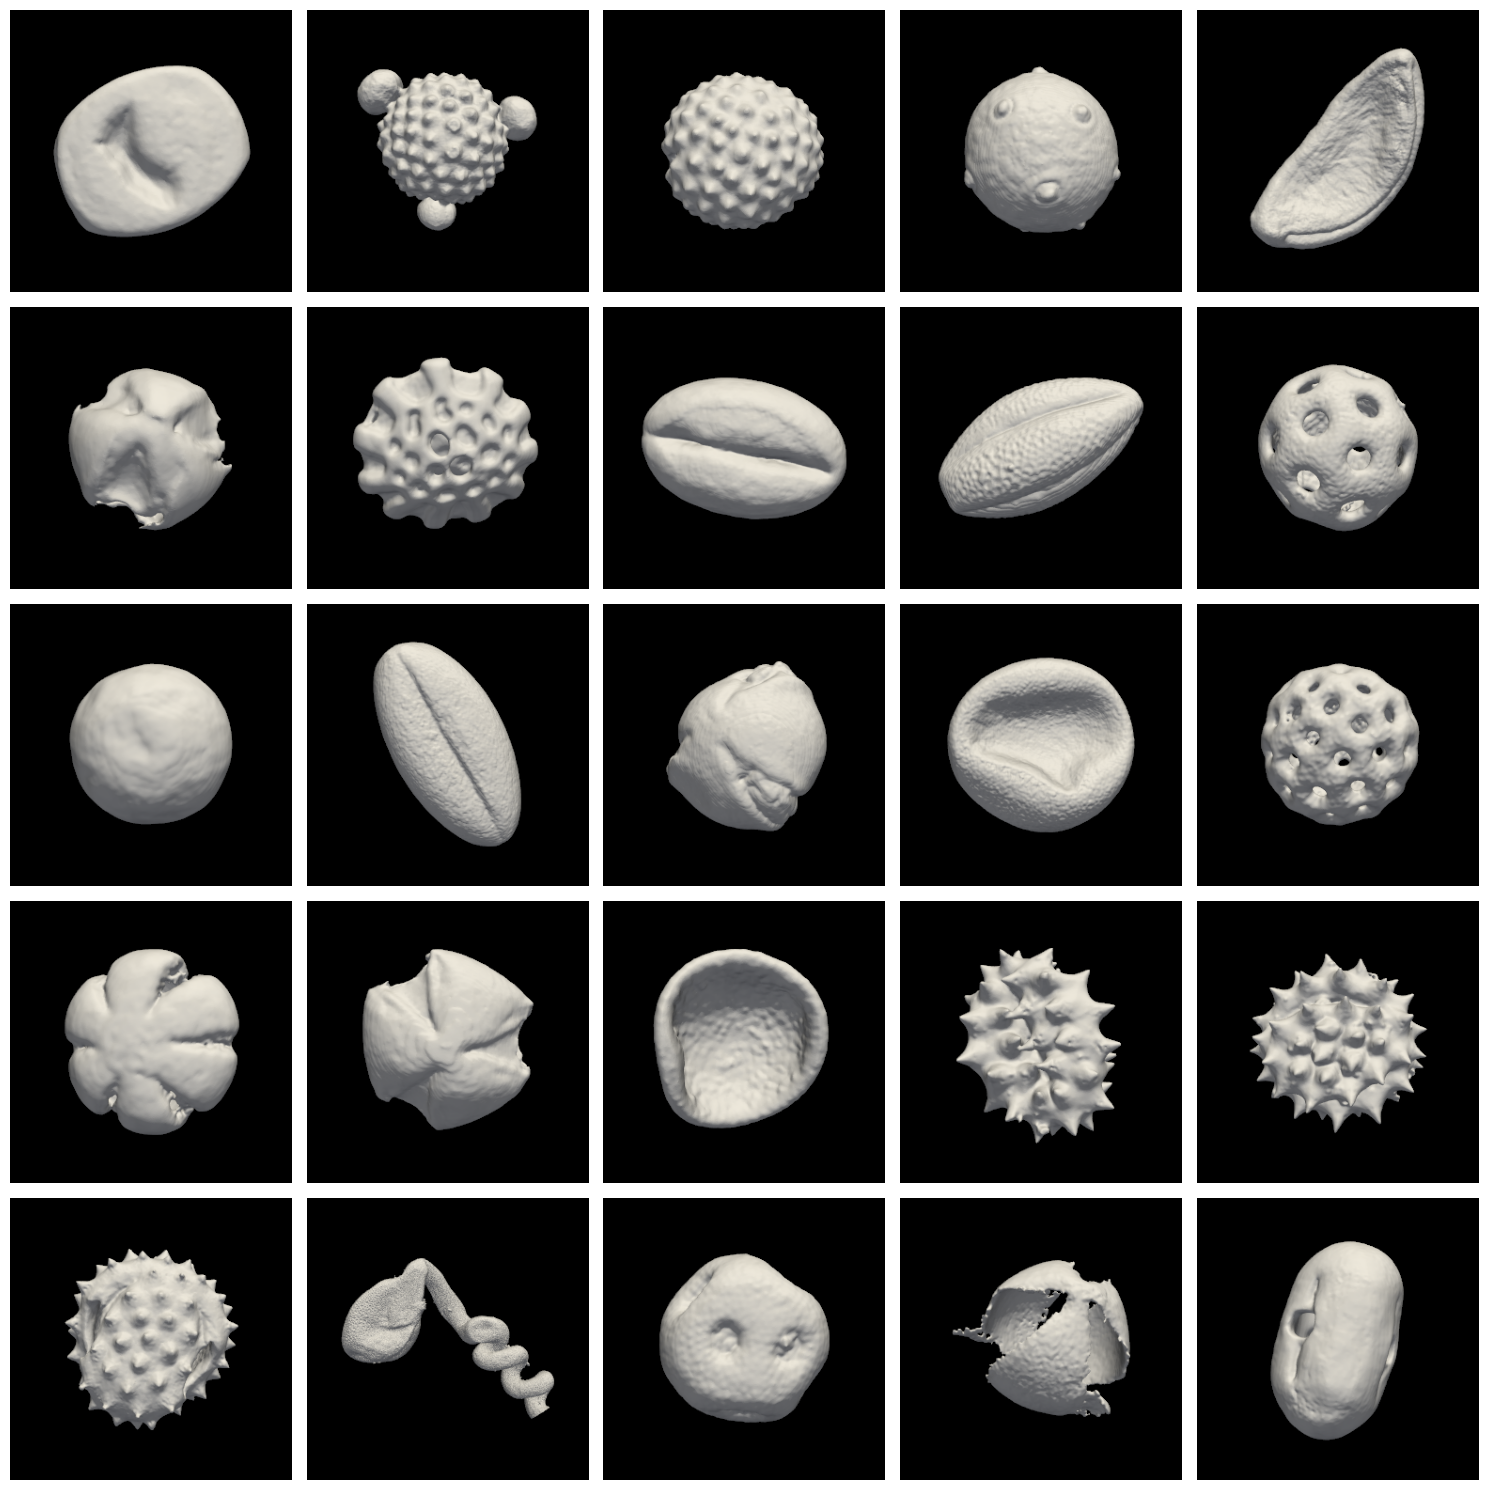

In [4]:
import os
import random
import pyvista as pv
import matplotlib.pyplot as plt
import seaborn as sns

pv.global_theme.allow_empty_mesh = True

sample_size = 25
sampled_files = random.sample(stl_files, sample_size) if len(stl_files) >= sample_size else stl_files

def get_mesh_screenshot(file_path, width=300, height=300):
    """
    Load a mesh and return a screenshot of it using PyVista in offscreen mode.
    
    Parameters:
        file_path (str): Path to the STL file.
        width (int): Width of the output image.
        height (int): Height of the output image.
        
    Returns:
        np.ndarray or None: The screenshot image as a numpy array, or None if the mesh is empty.
    """
    # Load the mesh
    mesh = pv.read(file_path)
    
    # Check if mesh is empty; if so, return None
    if mesh.n_points == 0:
        print(f"Warning: Mesh at {file_path} is empty. Skipping.")
        return None
    
    # Create a PyVista Plotter in offscreen mode to render the mesh
    plotter = pv.Plotter(off_screen=True, window_size=(width, height))
    plotter.add_mesh(mesh, color="white")
    
    # Optionally, set a fixed camera position (e.g., top-down view) to standardize the view
    plotter.camera_position = 'xy'
    plotter.background_color = 'black'
    
    # Capture the screenshot
    img = plotter.screenshot(transparent_background=False)
    plotter.close()
    return img

# Generate screenshots for each sampled mesh (skip any that return None)
screenshots = []
for file in sampled_files:
    file_path = os.path.join(RAW_MESHES_DIR, file)
    img = get_mesh_screenshot(file_path)
    if img is not None:
        screenshots.append(img)

# Check that we have enough screenshots to fill a 10x10 grid
if len(screenshots) < 25:
    print(f"Only {len(screenshots)} valid meshes found. Adjusting grid layout accordingly.")
    n_rows = n_cols = int(len(screenshots) ** 0.5) or 1
else:
    n_rows, n_cols = 5, 5

# Now, set up the grid using Matplotlib with Seaborn styling
#sns.set_theme(style="whitegrid")  # Apply a Seaborn theme

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

# Plot each screenshot into the grid
for i, ax in enumerate(axes):
    if i < len(screenshots):
        ax.imshow(screenshots[i])
    ax.axis("off")  # Hide axes for clarity

plt.tight_layout()
plt.show()


In [5]:

def load_mesh(file_path):
    """
    Load an STL file and return a PyVista mesh object.
    
    Parameters:
        file_path (str): Path to the STL file.
    
    Returns:
        pv.PolyData: The loaded mesh.
    """
    mesh = pv.read(file_path)
    return mesh

def visualize_mesh(mesh, notebook=True):
    """
    Visualize the provided PyVista mesh.
    
    Parameters:
        mesh (pv.PolyData): The mesh to visualize.
        notebook (bool): Whether to render in a Jupyter notebook environment.
    """
    mesh.plot(notebook=notebook)


if stl_files:
    first_file_path = os.path.join(RAW_MESHES_DIR, stl_files[207])
    mesh_data = load_mesh(first_file_path)
    
    visualize_mesh(mesh_data, notebook=True)
else:
    print("No STL files found in the specified folder.")

Widget(value='<iframe src="http://localhost:63536/index.html?ui=P_0x29ed72dca90_0&reconnect=auto" class="pyvis…

## Mesh Properties

In [ ]:
import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm

def compute_mesh_properties(mesh):
    """
    Compute key properties of a mesh using vectorized operations.
    
    Assumes that the mesh is triangulated.
    
    Returns a dictionary with:
      - n_vertices: number of vertices in the mesh.
      - n_faces: number of faces (using n_cells).
      - avg_edge_length: mean length of all edges.
      - std_edge_length: standard deviation of the edge lengths.
      - avg_normal_magnitude: average magnitude of point normals (if available).
    """
    n_vertices = mesh.n_points
    # Use n_cells to avoid deprecation warning
    n_faces = mesh.n_cells  

    pts = mesh.points

    try:
        faces = mesh.faces.reshape((-1, 4))[:, 1:4]  # shape: (n_faces, 3)
    except Exception as e:
        print("Error reshaping faces. Mesh may not be triangulated.")
        return None

    # Vectorized extraction of triangle vertices: shape (n_faces, 3, 3)
    face_pts = pts[faces]

    # Compute edge vectors for each triangle
    edge1 = face_pts[:, 1] - face_pts[:, 0]
    edge2 = face_pts[:, 2] - face_pts[:, 1]
    edge3 = face_pts[:, 0] - face_pts[:, 2]

    # Compute lengths for each edge
    lengths1 = np.linalg.norm(edge1, axis=1)
    lengths2 = np.linalg.norm(edge2, axis=1)
    lengths3 = np.linalg.norm(edge3, axis=1)

    # Combine all edge lengths and compute statistics
    all_lengths = np.concatenate([lengths1, lengths2, lengths3])
    avg_edge_length = np.mean(all_lengths)
    std_edge_length = np.std(all_lengths)

    # Compute average normal magnitude if normals are available
    if hasattr(mesh, 'point_normals') and mesh.point_normals is not None:
        normals = mesh.point_normals
        avg_normal_magnitude = np.mean(np.linalg.norm(normals, axis=1))
    else:
        avg_normal_magnitude = None

    return {
        'n_vertices': n_vertices,
        'n_faces': n_faces,
        'avg_edge_length': avg_edge_length,
        'std_edge_length': std_edge_length,
        'avg_normal_magnitude': avg_normal_magnitude
    }

def process_file(file_path):
    """
    Helper function to process a single file. Returns mesh properties.
    """
    try:
        mesh = pv.read(file_path)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None
    if mesh.n_points == 0:
        print(f"Skipping empty mesh: {file_path}")
        return None
    props = compute_mesh_properties(mesh)
    return props

def analyze_dataset_properties(raw_meshes_dir):
    """
    Process all STL files in the specified directory in parallel using Joblib,
    compute mesh properties, and then print and plot the mean and standard deviation
    for each property.
    """
    stl_files = [file for file in os.listdir(raw_meshes_dir) if file.endswith(".stl")]
    file_paths = [os.path.join(raw_meshes_dir, file) for file in stl_files]

    # Process files in parallel using joblib with a progress bar
    results = Parallel(n_jobs=-1)(
        delayed(process_file)(fp) for fp in tqdm(file_paths, desc="Processing meshes")
    )

    # Filter out None results
    results = [r for r in results if r is not None]
    
    if not results:
        print("No valid meshes processed.")
        return

    # Aggregate properties across all meshes
    vertices_list = [r['n_vertices'] for r in results]
    faces_list = [r['n_faces'] for r in results]
    edge_length_list = [r['avg_edge_length'] for r in results]
    edge_length_std_list = [r['std_edge_length'] for r in results]
    normal_mag_list = [r['avg_normal_magnitude'] for r in results if r['avg_normal_magnitude'] is not None]

    summary = {
        'n_vertices': (np.mean(vertices_list), np.std(vertices_list)),
        'n_faces': (np.mean(faces_list), np.std(faces_list)),
        'avg_edge_length': (np.mean(edge_length_list), np.std(edge_length_list)),
        'edge_length_std': (np.mean(edge_length_std_list), np.std(edge_length_std_list))
    }
    if normal_mag_list:
        summary['avg_normal_magnitude'] = (np.mean(normal_mag_list), np.std(normal_mag_list))
    
    # Print summary
    print("Dataset Mesh Properties Summary (mean ± std):")
    for key, (mean_val, std_val) in summary.items():
        print(f"  {key}: {mean_val:.2f} ± {std_val:.2f}")
    
    # Plot summary using error bars
    prop_names = list(summary.keys())
    means = [summary[k][0] for k in prop_names]
    stds = [summary[k][1] for k in prop_names]
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    plt.bar(prop_names, means, yerr=stds, capsize=5, color='skyblue')
    plt.ylabel("Value")
    plt.title("Mean and Standard Deviation of Mesh Properties")
    plt.show()

analyze_dataset_properties(RAW_MESHES_DIR)


Processing meshes:   0%|          | 0/208 [00:00<?, ?it/s]